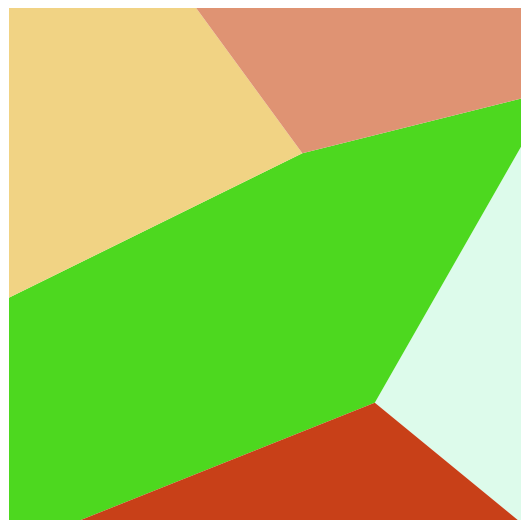

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions, new_vertices = [], vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        verts = vor.regions[region]
        if verts and all(v >= 0 for v in verts):
            new_regions.append(verts)
            continue
        new_region = [v for v in verts if v >= 0]
        for p2, v1, v2 in all_ridges[p1]:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]; t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        ang = np.arctan2(vs[:,1]-c[1], vs[:,0]-c[0])
        new_regions.append(np.array(new_region)[np.argsort(ang)].tolist())
    return new_regions, np.asarray(new_vertices)

# ----------------- MAIN -----------------
N_GRAIN = 5
SEED = 200
OUTPUT_PX = 512        # <-- square output size in pixels (e.g., 1024, 2048, 4096)

np.random.seed(SEED)
points = np.random.rand(N_GRAIN, 2)
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# random vivid colors per cell
colors = np.random.rand(N_GRAIN, 3)

# --- Build a square canvas with exact OUTPUT_PX x OUTPUT_PX ---
inch = 6.0
dpi = OUTPUT_PX / inch
fig = plt.figure(figsize=(inch, inch), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])     # fill entire figure (no margins)

# draw cells
for i, region in enumerate(regions):
    poly = vertices[region]
    ax.fill(*zip(*poly), facecolor=colors[i % len(colors)], edgecolor="none")

# square domain and no axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")
ax.set_axis_off()

# transparent background, fixed pixel size (no bbox cropping!)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
fig.savefig(f'./image/voronoi_{N_GRAIN}.png', transparent=True)


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
# import caas_jupyter_tools


IMAGE_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/image'

N_GRAIN = 5
# ---- Load image ----
IMAGE_PATH = fr"./image/voronoi_{N_GRAIN}.png"  # provided path
img = Image.open(IMAGE_PATH).convert("RGB")
img_array = np.array(img)
H, W, _ = img_array.shape
total_pixels = H * W

# ---- Unique colors & counts (exact color segmentation, no sklearn) ----
unique_colors, counts = np.unique(img_array.reshape(-1, 3), axis=0, return_counts=True)

# ---- Compute percentages ----
percentages = counts / total_pixels * 100.0

# ---- Filter: only keep regions >= 1% ----
mask = percentages >= 0.1
kept_colors = unique_colors[mask]
kept_counts = counts[mask]
kept_percentages = percentages[mask]

# ---- Prepare results table ----
areas_df = pd.DataFrame({
    "Color (RGB)": [tuple(c) for c in kept_colors],
    "Pixel Count": kept_counts,
    "Percentage (%)": kept_percentages
}).sort_values("Pixel Count", ascending=False).reset_index(drop=True)

# ---- Build label map for boundaries (all regions) ----
# map each unique color to an id (for edges), but we'll draw boundaries using ALL colors
color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors)}
seg_labels = np.array([color_to_id[tuple(c)] for c in img_array.reshape(-1,3)]).reshape(H, W)

# ---- Compute boundaries ----
boundary_mask = np.zeros((H, W), dtype=bool)
boundary_mask[1:, :] |= (seg_labels[1:, :] != seg_labels[:-1, :])
boundary_mask[:, 1:] |= (seg_labels[:, 1:] != seg_labels[:, :-1])
kernel = np.ones((3,3), np.uint8)
boundary_mask_dilated = cv2.dilate(boundary_mask.astype(np.uint8)*255, kernel, iterations=1).astype(bool)

# ---- Overlay boundaries on original image ----
with_bnd = img_array.copy()
with_bnd[boundary_mask_dilated] = (0,0,0)

# ---- Save outputs ----
# Image.fromarray(with_bnd).save("/mnt/data/with_boundaries.png")
# areas_df.to_csv("/mnt/data/areas_over_1pct.csv", index=False)

# ---- Show ----
plt.figure(figsize=(6,6))
plt.title("Original Image with Boundaries")
plt.imshow(with_bnd)
plt.axis("off")
plt.savefig(Path(IMAGE_DIR_WIN, fr'boundary_grains_{N_GRAIN}.png'))


# print(areas_df)

true_area = 1
equi_r = np.sqrt(np.array(kept_percentages/100 * true_area)/np.pi)

# Reorder equi_r and colors by value (descending)
order = np.argsort(-equi_r)
equi_r_sorted = equi_r[order]
kept_colors_sorted = kept_colors[order]

# Prepare labels as index after sorting
labels = list(range(len(kept_colors_sorted)))

# Plot bar chart
plt.figure(figsize=(8,6))
plt.bar(labels, equi_r_sorted, color=np.array(kept_colors_sorted)/255.0)
plt.ylabel("Equivalent Radius (normalized units)")
plt.xlabel("Region Index (sorted)")
plt.title("Equivalent Circle Radius of Regions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, fr'bar_grains_{N_GRAIN}.png'))


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
# import caas_jupyter_tools


IMAGE_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/image'

N_GRAIN = 5
# ---- Load image ----
IMAGE_PATH = fr"./image/voronoi_{N_GRAIN}.png"  # provided path
img = Image.open(IMAGE_PATH).convert("RGB")
img_array = np.array(img)
H, W, _ = img_array.shape
total_pixels = H * W

# ---- Unique colors & counts (exact color segmentation, no sklearn) ----
unique_colors, counts = np.unique(img_array.reshape(-1, 3), axis=0, return_counts=True)

# ---- Compute percentages ----
percentages = counts / total_pixels * 100.0

# ---- Filter: only keep regions >= 1% ----
mask = percentages >= 0.1
kept_colors = unique_colors[mask]
kept_counts = counts[mask]
kept_percentages = percentages[mask]

# ---- Prepare results table ----
areas_df = pd.DataFrame({
    "Color (RGB)": [tuple(c) for c in kept_colors],
    "Pixel Count": kept_counts,
    "Percentage (%)": kept_percentages
}).sort_values("Pixel Count", ascending=False).reset_index(drop=True)

# ---- Build label map for boundaries (all regions) ----
# map each unique color to an id (for edges), but we'll draw boundaries using ALL colors
color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors)}
seg_labels = np.array([color_to_id[tuple(c)] for c in img_array.reshape(-1,3)]).reshape(H, W)

# ---- Compute boundaries ----
boundary_mask = np.zeros((H, W), dtype=bool)
boundary_mask[1:, :] |= (seg_labels[1:, :] != seg_labels[:-1, :])
boundary_mask[:, 1:] |= (seg_labels[:, 1:] != seg_labels[:, :-1])
kernel = np.ones((3,3), np.uint8)
boundary_mask_dilated = cv2.dilate(boundary_mask.astype(np.uint8)*255, kernel, iterations=1).astype(bool)

# ---- Overlay boundaries on original image ----
with_bnd = img_array.copy()
with_bnd[boundary_mask_dilated] = (0,0,0)

# ---- Save outputs ----
# Image.fromarray(with_bnd).save("/mnt/data/with_boundaries.png")
# areas_df.to_csv("/mnt/data/areas_over_1pct.csv", index=False)

# ---- Show ----
plt.figure(figsize=(6,6))
plt.title("Original Image with Boundaries")
plt.imshow(with_bnd)
plt.axis("off")
plt.savefig(Path(IMAGE_DIR_WIN, fr'boundary_grains_{N_GRAIN}.png'))


# print(areas_df)

true_area = 1
equi_r = np.sqrt(np.array(kept_percentages/100 * true_area)/np.pi)

# Reorder equi_r and colors by value (descending)
order = np.argsort(-equi_r)
equi_r_sorted = equi_r[order]
kept_colors_sorted = kept_colors[order]

# Prepare labels as index after sorting
labels = list(range(len(kept_colors_sorted)))

# Plot bar chart
plt.figure(figsize=(8,6))
plt.bar(labels, equi_r_sorted, color=np.array(kept_colors_sorted)/255.0)
plt.ylabel("Equivalent Radius (normalized units)")
plt.xlabel("Region Index (sorted)")
plt.title("Equivalent Circle Radius of Regions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, fr'bar_grains_{N_GRAIN}.png'))



from collections import Counter

# --- Sort grains by area (largest first) ---
order = np.argsort(-kept_counts)   # descending order by pixel count
kept_colors_sorted = kept_colors[order]

# Map sorted colors to grain IDs 0..N-1
color_to_gid = {tuple(color): idx for idx, color in enumerate(kept_colors_sorted)}

# Rebuild seg_labels restricted to kept regions, using sorted IDs
seg_labels = np.full((H, W), fill_value=-1, dtype=int)
for color, gid in color_to_gid.items():
    mask = np.all(img_array == color, axis=-1)
    seg_labels[mask] = gid
    
    

def point_to_grain_id_norm(x, y, seg_labels=seg_labels, boundary_mask=boundary_mask_dilated):
    """
    Return the grain ID for normalized coordinates (x,y) in [0,1]x[0,1],
    origin bottom-left. Grain IDs are sorted by area (0 = largest).
    """
    H, W = seg_labels.shape
    col = int(round(x * (W - 1)))
    row = int(round((1 - y) * (H - 1)))  # flip y for image coords

    gid = int(seg_labels[row, col])

    # Boundary handling (choose most common neighbor label)
    if gid == -1 or boundary_mask[row, col]:
        neigh_ids = []
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
            rr, cc = row + dr, col + dc
            if 0 <= rr < H and 0 <= cc < W and seg_labels[rr, cc] != -1:
                neigh_ids.append(int(seg_labels[rr, cc]))
        if neigh_ids:
            gid = Counter(neigh_ids).most_common(1)[0][0]

    return gid


gid = point_to_grain_id_norm(0.5, 1)  # returns an int like 12
gid

In [4]:
from dataclasses import dataclass
from pathlib import Path
from collections import Counter
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt


@dataclass
class VoronoiGrainIndexer:
    """
    Index Voronoi regions from a color PNG and query the grain ID for a point.

    - Coordinates are normalized: (x, y) in [0,1] x [0,1], origin at bottom-left.
    - Grain IDs are assigned ONLY to regions that pass the percentage threshold,
      and are sorted by area descending: gid=0 is the largest kept region.
    - Pixels not belonging to a kept region are labelled -1.
    """
    image_path: str
    min_percent: float = 0.1       # keep regions with area >= this percent
    dilate_iters: int = 1          # boundary dilation iterations for robust edge detection

    # Internal state (populated by process())
    img_array: Optional[np.ndarray] = None
    H: Optional[int] = None
    W: Optional[int] = None
    areas_df: Optional[pd.DataFrame] = None
    kept_colors_sorted: Optional[np.ndarray] = None
    color_to_gid: Optional[dict] = None
    seg_labels: Optional[np.ndarray] = None
    boundary_mask_dilated: Optional[np.ndarray] = None

    def process(self) -> None:
        """Load image, segment colors, compute areas, build grain labels and boundaries."""
        # ---- Load image ----
        img = Image.open(self.image_path).convert("RGB")
        self.img_array = np.array(img)
        self.H, self.W, _ = self.img_array.shape

        # ---- Unique colors & counts ----
        unique_colors, counts = np.unique(
            self.img_array.reshape(-1, 3), axis=0, return_counts=True
        )
        total_pixels = self.H * self.W
        percentages = counts / total_pixels * 100.0

        # ---- Keep regions by percentage threshold ----
        keep_mask = percentages >= self.min_percent
        kept_colors = unique_colors[keep_mask]
        kept_counts = counts[keep_mask]
        kept_percentages = percentages[keep_mask]

        # ---- Area table (unsorted) ----
        areas_df = pd.DataFrame({
            "Color (RGB)": [tuple(c) for c in kept_colors],
            "Pixel Count": kept_counts,
            "Percentage (%)": kept_percentages
        })

        # ---- Sort by area (descending) and build color->gid map ----
        order = np.argsort(-kept_counts)  # largest first
        self.kept_colors_sorted = kept_colors[order]
        kept_counts_sorted = kept_counts[order]
        kept_percentages_sorted = kept_percentages[order]

        self.areas_df = areas_df.iloc[order].reset_index(drop=True)
        self.color_to_gid = {tuple(color): idx for idx, color in enumerate(self.kept_colors_sorted)}

        # ---- Build seg_labels restricted to kept regions (others = -1) ----
        self.seg_labels = np.full((self.H, self.W), fill_value=-1, dtype=int)
        for color, gid in self.color_to_gid.items():
            mask = np.all(self.img_array == color, axis=-1)
            self.seg_labels[mask] = gid

        # ---- Build boundary mask from seg_labels ----
        boundary_mask = np.zeros((self.H, self.W), dtype=bool)
        # vertical boundaries (row-wise change)
        boundary_mask[1:, :] |= (self.seg_labels[1:, :] != self.seg_labels[:-1, :])
        # horizontal boundaries (col-wise change)
        boundary_mask[:, 1:] |= (self.seg_labels[:, 1:] != self.seg_labels[:, :-1])

        # Dilate (optional) to make boundary robust
        kernel = np.ones((3, 3), np.uint8)
        self.boundary_mask_dilated = cv2.dilate(
            boundary_mask.astype(np.uint8) * 255, kernel, iterations=self.dilate_iters
        ).astype(bool)

    # ---------- Queries & utilities ----------

    def point_to_grain_id(self, x: float, y: float) -> int:
        """
        Return the grain ID for normalized (x,y) in [0,1]x[0,1], origin at bottom-left.
        Grain IDs are sorted by area (0 = largest). Returns -1 if outside kept regions.
        """
        if self.seg_labels is None:
            raise RuntimeError("Call .process() before querying.")

        if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0):
            raise ValueError(f"coords must be in [0,1], got ({x},{y})")

        col = int(round(x * (self.W - 1)))
        row = int(round((1 - y) * (self.H - 1)))  # flip y to image coords

        gid = int(self.seg_labels[row, col])

        # Handle boundary/unknown by local voting for stability
        if gid == -1 or self.boundary_mask_dilated[row, col]:
            neigh_ids = []
            for dr, dc in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
                rr, cc = row + dr, col + dc
                if 0 <= rr < self.H and 0 <= cc < self.W and self.seg_labels[rr, cc] != -1:
                    neigh_ids.append(int(self.seg_labels[rr, cc]))
            if neigh_ids:
                gid = Counter(neigh_ids).most_common(1)[0][0]

        return gid

    def show_boundary_overlay(self, save_path: str | Path = None) -> None:
        """Show or save an image with boundaries overlaid in black."""
        if self.img_array is None or self.boundary_mask_dilated is None:
            raise RuntimeError("Call .process() before saving overlays.")

        overlay = self.img_array.copy()
        overlay[self.boundary_mask_dilated] = (0, 0, 0)

        if save_path:
            Image.fromarray(overlay).save(str(save_path))
        else:
            plt.figure(figsize=(6,6))
            plt.title("Image with Boundaries")
            plt.imshow(overlay)
            plt.axis("off")
            plt.show()

    def plot_bar_chart(self, save_path: str | Path = None,
                    title: str = "Equivalent Circle Radius of Regions") -> None:
        """
        Show or save bar chart of equivalent radii (normalized true area=1).
        """
        if self.areas_df is None or self.kept_colors_sorted is None:
            raise RuntimeError("Call .process() before plotting.")

        true_area = 1.0
        pct = self.areas_df["Percentage (%)"].to_numpy() / 100.0
        equi_r = np.sqrt(pct * true_area / np.pi)

        labels = list(range(len(equi_r)))
        colors = (self.kept_colors_sorted / 255.0)

        plt.figure(figsize=(8, 6))
        plt.bar(labels, equi_r, color=colors)
        plt.ylabel("Equivalent Radius (normalized units)")
        plt.xlabel("Region Index (sorted by area)")
        plt.title(title)
        plt.xticks(labels)
        plt.tight_layout()

        if save_path:
            plt.savefig(str(save_path))
            plt.close()
        else:
            plt.show()

    def get_areas_table(self) -> pd.DataFrame:
        """
        Return a copy of the areas table (sorted by area).
        Columns: 'Color (RGB)', 'Pixel Count', 'Percentage (%)'
        """
        if self.areas_df is None:
            raise RuntimeError("Call .process() before accessing areas.")
        return self.areas_df.copy()

    def color_for_gid(self, gid: int) -> Tuple[int, int, int]:
        """Return the RGB tuple for a given grain id (sorted by area)."""
        if self.kept_colors_sorted is None:
            raise RuntimeError("Call .process() first.")
        if not (0 <= gid < len(self.kept_colors_sorted)):
            raise ValueError(f"gid {gid} out of range [0, {len(self.kept_colors_sorted)-1}]")
        c = self.kept_colors_sorted[gid]
        return (int(c[0]), int(c[1]), int(c[2]))
    


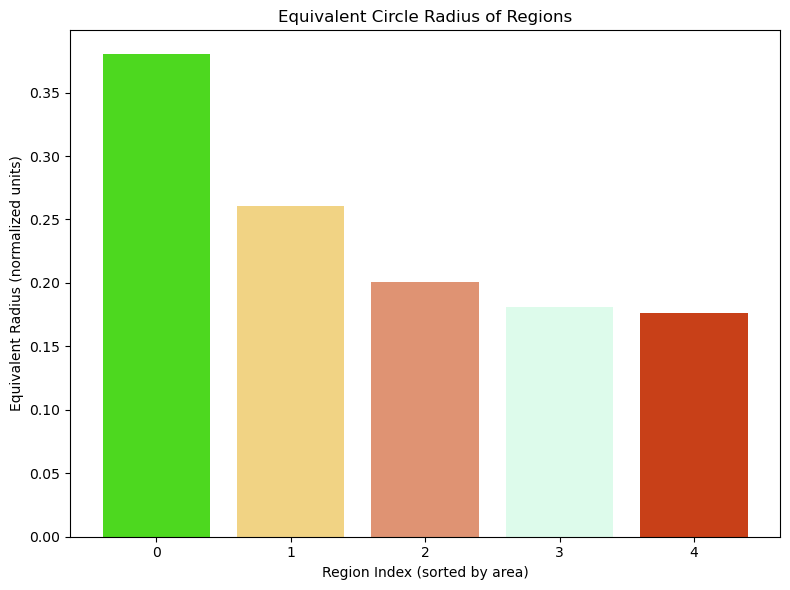

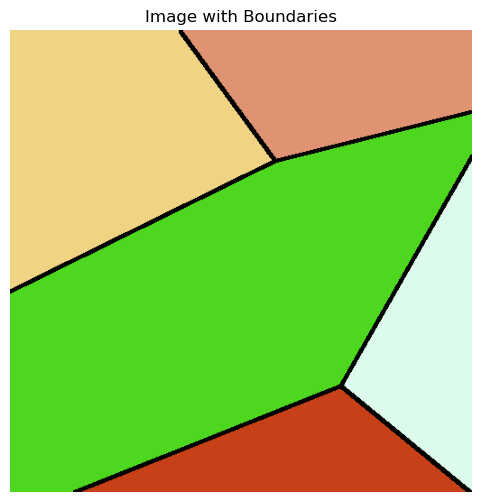

In [ ]:
indexer = VoronoiGrainIndexer("./image/voronoi_5.png", min_percent=0.1, dilate_iters=1)
indexer.process()
indexer.plot_bar_chart()
indexer.show_boundary_overlay()


In [ ]:
x, y = 0.5, 0.5
H, W = seg_labels.shape
row, col = _rc_from_norm(x, y, W, H)
col